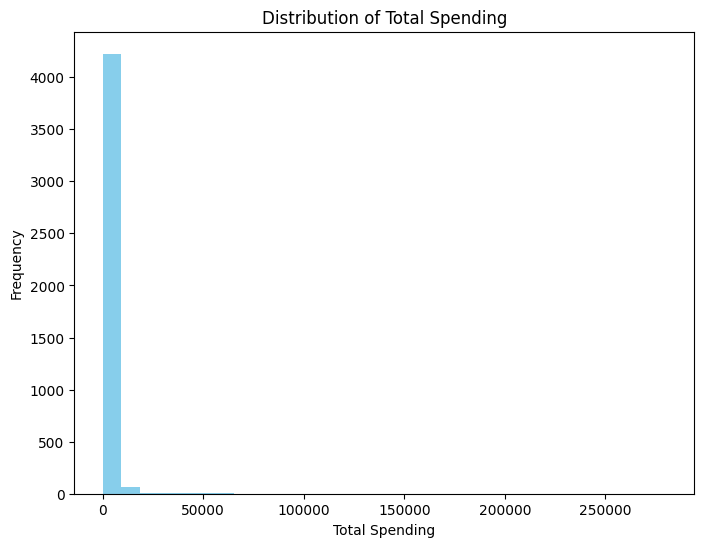

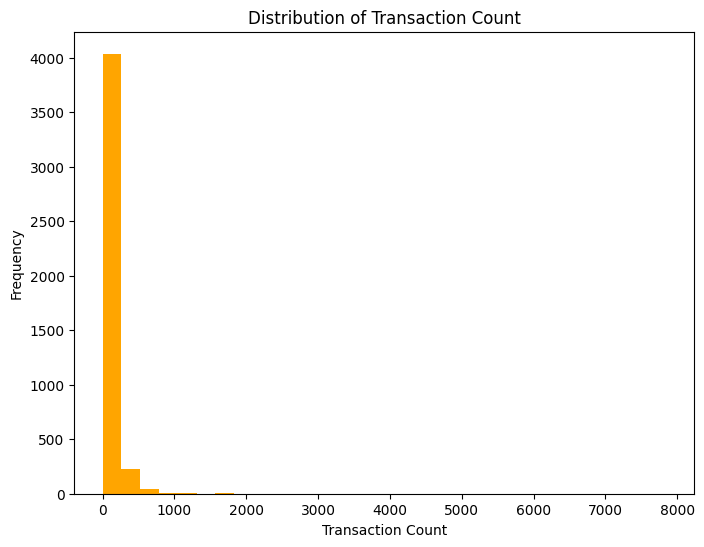

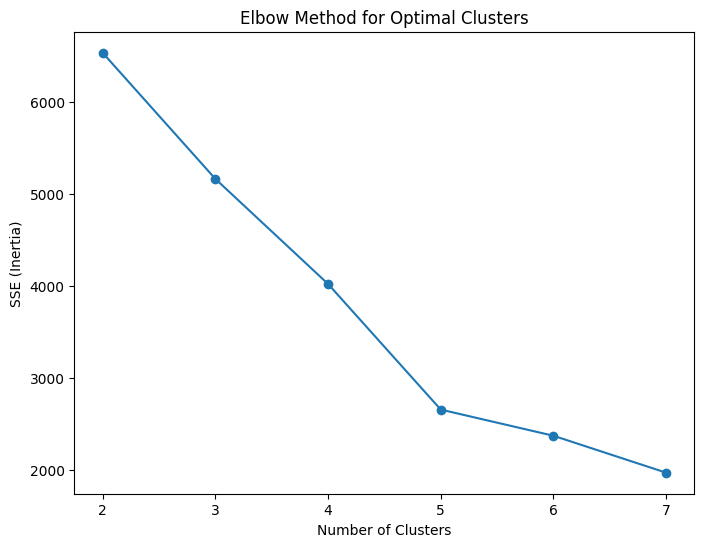

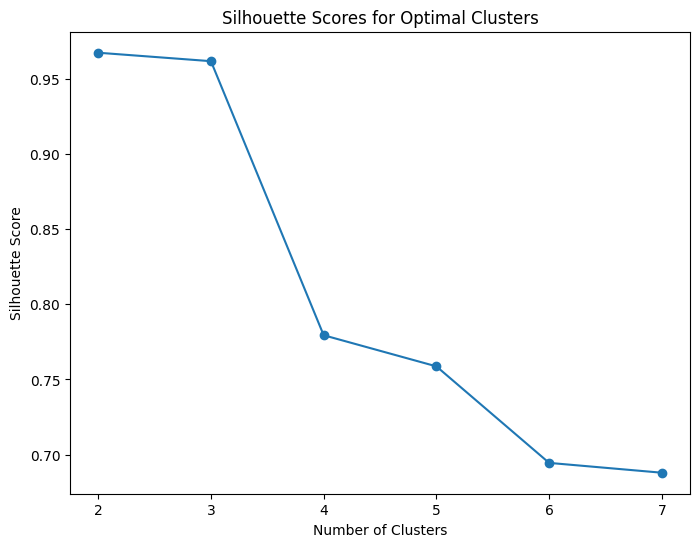

Cluster Summary:
            TotalPrice  TransactionCount       Quantity
Cluster                                                
0          1019.413880         57.767384     604.056778
1        225721.652500        711.750000  103007.250000
2         77005.738571       2373.357143   50060.000000
3          8865.913851        406.385093    5092.931677


['/content/scaler.pkl']

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import zipfile
from flask import Flask, request, jsonify

# Step 1: Load the Dataset
# Unzip and load the dataset
zip_path = "/content/archive (1).zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")

# Load the dataset
data = pd.read_excel("/content/Online Retail.xlsx")

# Step 2: Data Cleaning
# Remove rows with missing CustomerID and invalid Quantity/UnitPrice
data_cleaned = data.dropna(subset=["CustomerID"])
data_cleaned = data_cleaned[(data_cleaned["Quantity"] > 0) & (data_cleaned["UnitPrice"] > 0)]

# Create TotalPrice for analysis
data_cleaned["TotalPrice"] = data_cleaned["Quantity"] * data_cleaned["UnitPrice"]

# Step 3: Feature Aggregation
customer_data = data_cleaned.groupby("CustomerID").agg({
    "TotalPrice": "sum",
    "InvoiceNo": "count",
    "Quantity": "sum"
}).rename(columns={"InvoiceNo": "TransactionCount"}).reset_index()

# Step 4: Exploratory Data Analysis (EDA)
# Spending Categories Distribution
plt.figure(figsize=(8, 6))
ax = customer_data["TotalPrice"].plot(kind="hist", bins=30, color="skyblue")
plt.title("Distribution of Total Spending")
plt.xlabel("Total Spending")
plt.ylabel("Frequency")
plt.show()

# Transaction Count Distribution
plt.figure(figsize=(8, 6))
ax = customer_data["TransactionCount"].plot(kind="hist", bins=30, color="orange")
plt.title("Distribution of Transaction Count")
plt.xlabel("Transaction Count")
plt.ylabel("Frequency")
plt.show()

# Step 5: Hyperparameter Tuning (Elbow Method and Silhouette Score)
scaler = StandardScaler()
features = customer_data[["TotalPrice", "TransactionCount", "Quantity"]]
scaled_features = scaler.fit_transform(features)

# Determine optimal clusters using the Elbow Method
sse = []
silhouette_scores = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(2, 8), sse, marker="o")
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE (Inertia)")
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 8), silhouette_scores, marker="o")
plt.title("Silhouette Scores for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

# Step 6: K-Means Clustering
# Choosing 4 clusters based on previous analysis
kmeans = KMeans(n_clusters=4, random_state=42)
customer_data["Cluster"] = kmeans.fit_predict(scaled_features)

# Analyze clusters
cluster_summary = customer_data.groupby("Cluster")[["TotalPrice", "TransactionCount", "Quantity"]].mean()
print("Cluster Summary:")
print(cluster_summary)

# Step 7: REST API Deployment
# Save model and scaler for deployment
import joblib
joblib.dump(kmeans, "/content/kmeans_model.pkl")
joblib.dump(scaler, "/content/scaler.pkl")





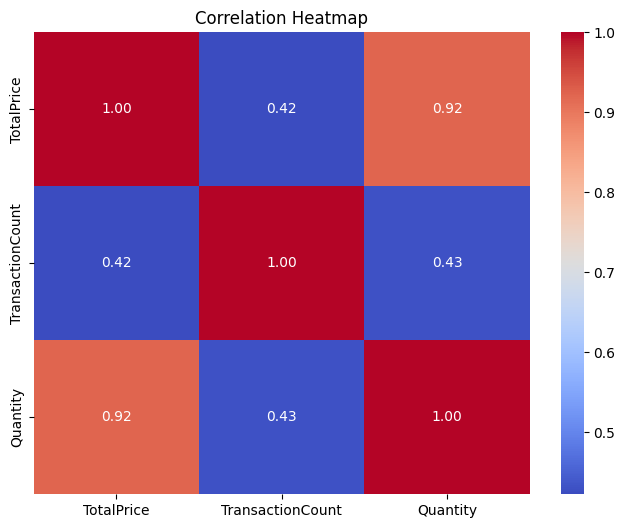

<ipython-input-4-319c82d64c94>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=customer_data, x="Cluster", y="TotalPrice", palette="viridis")


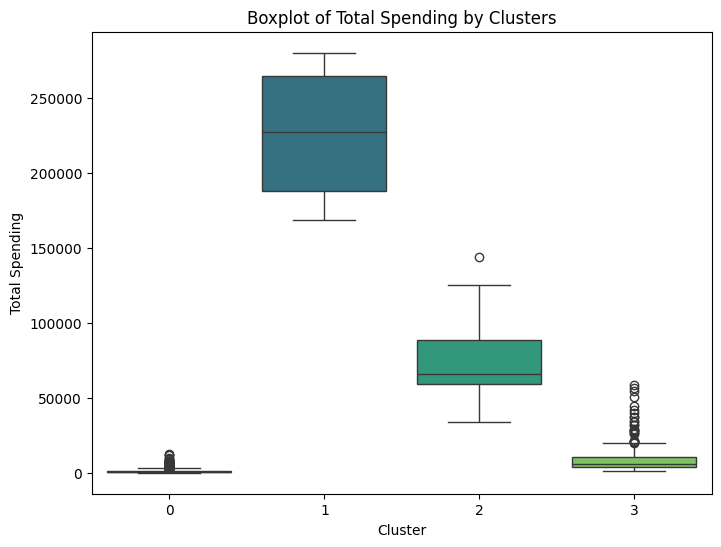

<ipython-input-4-319c82d64c94>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=customer_data, x="Cluster", y="TransactionCount", palette="magma")


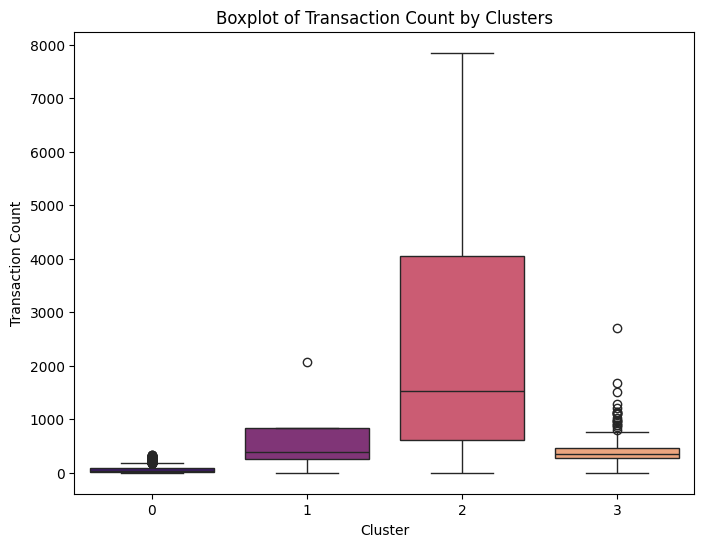

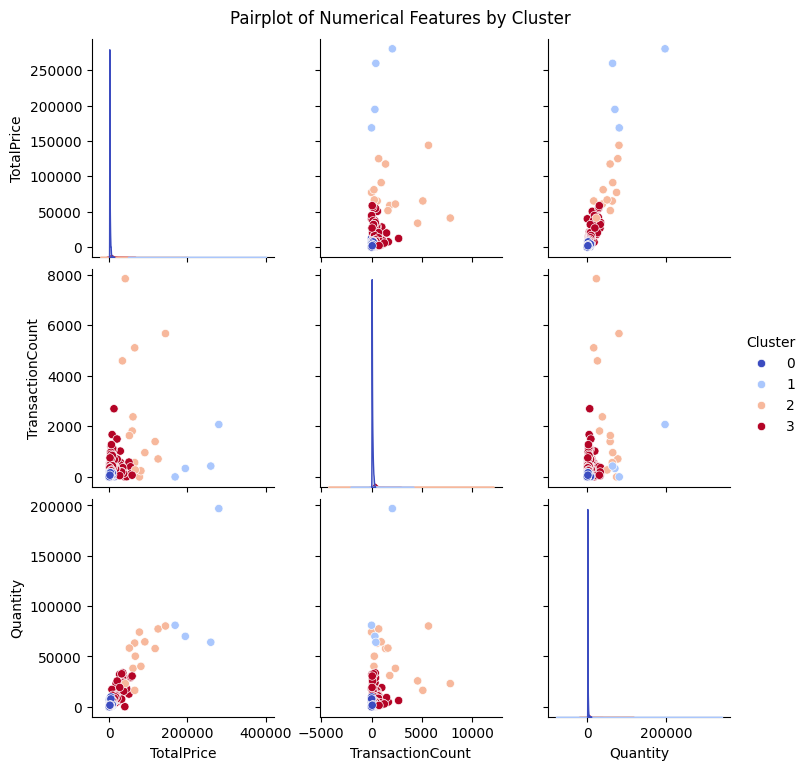

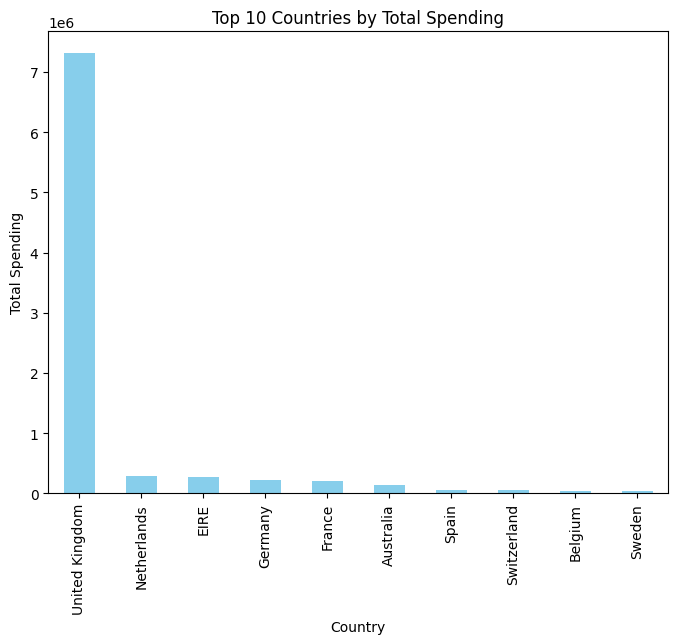

In [4]:
# Additional EDA Graphs

# Correlation Heatmap
plt.figure(figsize=(8, 6))
corr_matrix = customer_data[["TotalPrice", "TransactionCount", "Quantity"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Boxplot of Total Spending by Clusters
plt.figure(figsize=(8, 6))
sns.boxplot(data=customer_data, x="Cluster", y="TotalPrice", palette="viridis")
plt.title("Boxplot of Total Spending by Clusters")
plt.xlabel("Cluster")
plt.ylabel("Total Spending")
plt.show()

# Boxplot of Transaction Count by Clusters
plt.figure(figsize=(8, 6))
sns.boxplot(data=customer_data, x="Cluster", y="TransactionCount", palette="magma")
plt.title("Boxplot of Transaction Count by Clusters")
plt.xlabel("Cluster")
plt.ylabel("Transaction Count")
plt.show()

# Pairplot of Numerical Features
sns.pairplot(customer_data, vars=["TotalPrice", "TransactionCount", "Quantity"], hue="Cluster", palette="coolwarm")
plt.suptitle("Pairplot of Numerical Features by Cluster", y=1.02)
plt.show()

# Country-Wise Spending
country_spending = data_cleaned.groupby("Country")["TotalPrice"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 6))
country_spending.plot(kind="bar", color="skyblue")
plt.title("Top 10 Countries by Total Spending")
plt.xlabel("Country")
plt.ylabel("Total Spending")
plt.show()


In [5]:
# Feature Aggregation with Frequency Segments
# Group by CustomerID to calculate total spending, transaction count, quantity, and unique invoice dates
customer_data = data_cleaned.groupby("CustomerID").agg({
    "TotalPrice": "sum",  # Total spending
    "InvoiceNo": "count",  # Transaction count
    "Quantity": "sum",  # Total quantity purchased
    "InvoiceDate": pd.Series.nunique  # Unique invoice dates for frequency analysis
}).rename(columns={"InvoiceNo": "TransactionCount", "InvoiceDate": "DistinctInvoiceDates"}).reset_index()

# Step 4: Frequency Segmentation
# Define frequency segments based on the number of distinct invoice dates
frequency_quantiles = customer_data["DistinctInvoiceDates"].quantile([0.33, 0.66])
customer_data["FrequencySegment"] = pd.cut(
    customer_data["DistinctInvoiceDates"],
    bins=[0, frequency_quantiles[0.33], frequency_quantiles[0.66], customer_data["DistinctInvoiceDates"].max()],
    labels=["Low Frequency", "Medium Frequency", "High Frequency"]
)

# Step 5: Verify the DataFrame
print(customer_data.head())



   CustomerID  TotalPrice  TransactionCount  Quantity  DistinctInvoiceDates  \
0     12346.0    77183.60                 1     74215                     1   
1     12347.0     4310.00               182      2458                     7   
2     12348.0     1797.24                31      2341                     4   
3     12349.0     1757.55                73       631                     1   
4     12350.0      334.40                17       197                     1   

   FrequencySegment  
0     Low Frequency  
1    High Frequency  
2  Medium Frequency  
3     Low Frequency  
4     Low Frequency  


In [6]:
from flask import Flask, request, jsonify
import pandas as pd
import zipfile

# Step 1: Extract the Excel file from the zip archive
zip_path = "/content/archive (1).zip"  # Path to the zip file
extracted_excel_path = "/content/Online Retail.xlsx"  # Path for the extracted Excel file
csv_path = "/content/customer_data.csv"  # Path for the converted CSV file

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")  # Extract all contents to /content/

# Step 2: Convert Excel to CSV
# Load the Excel file
data = pd.read_excel(extracted_excel_path)

# Save the Excel data as a CSV file
data.to_csv(csv_path, index=False)

# Step 3: Load the preprocessed customer_data DataFrame
customer_data = pd.read_csv(csv_path)

# Step 4: Initialize the Flask app
app = Flask(__name__)

@app.route("/get_frequency_segment", methods=["POST"])
def get_frequency_segment():
    # Extract the CustomerID from the request JSON
    data = request.json
    customer_id = data.get("CustomerID")

    # Check if CustomerID is provided
    if not customer_id:
        return jsonify({"error": "CustomerID is required"}), 400

    # Query the DataFrame for the given CustomerID
    try:
        customer_id = int(customer_id)  # Ensure CustomerID is treated as an integer
    except ValueError:
        return jsonify({"error": "CustomerID must be an integer"}), 400

    customer_info = customer_data[customer_data["CustomerID"] == customer_id]

    # If CustomerID is not found, return an error
    if customer_info.empty:
        return jsonify({"error": f"CustomerID {customer_id} not found"}), 404

    # Extract the frequency segment
    if "FrequencySegment" not in customer_info.columns:
        return jsonify({"error": "FrequencySegment column not found in the data"}), 500

    frequency_segment = customer_info.iloc[0]["FrequencySegment"]

    # Return the frequency segment as a JSON response
    return jsonify({"CustomerID": customer_id, "FrequencySegment": frequency_segment})

# To run locally, uncomment the line below
# app.run(debug=True)
